# debug_interpz_order

The problem seems to be with fast_interp3D

I have wrong values, seemingly when I do not specify target and initial z_grid with the same ordering (i.e. increasing / decreasing)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "serif"

import numpy as np
import scipy.interpolate as itp
import xarray as xr
xu = xr.ufuncs
import crocosi.gridop as gop

In [2]:
dep_range = (10, .1)
np_zi = -np.logspace(np.log10(dep_range[0]), np.log10(dep_range[1]), 20)
np_dt = np.array([.5, 5, 9])

fun_val = lambda z: np.exp(z/10)**2
temp = fun_val(np_zi)

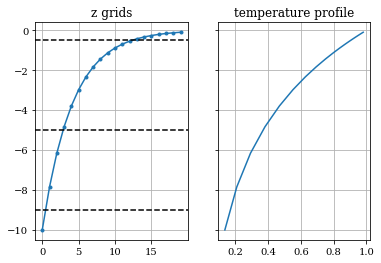

In [3]:
fig, axs = plt.subplots(1,2, sharey=True)

ax = axs[0]
axs[0].plot(np_zi, ".-")
for z in np_dt:
    ax.axhline(-z, color="k", linestyle="--")
ax.set_title("z grids")

ax = axs[1]
ax.plot(temp, np_zi)
ax.set_title("temperature profile")

for ax in axs:
    ax.grid(True)

In [4]:
d_t = xr.DataArray(np_dt, dims="depth") # increasing depth (downward z)
z_t = xr.DataArray(-np_dt[::-1], dims="z") # upward z (decreasing depth)

da = xr.DataArray(temp, 
                  coords={"z_rho":xr.DataArray(np_zi, dims="s_rho")}, 
                  dims="s_rho", 
                  name="temp"
                 )

da_r = xr.DataArray(temp[::-1], # same dataset with reversed order
                  coords={"z_rho":xr.DataArray(np_zi[::-1], dims="s_rho")}, 
                  dims="s_rho", 
                  name="temp"
                 )

da

<xarray.DataArray 'temp' (s_rho: 20)>
array([0.13533528, 0.20814508, 0.29179715, 0.38037942, 0.46835064,
       0.55141351, 0.62678964, 0.6930895 , 0.74999407, 0.79790353,
       0.83763456, 0.87019447, 0.89663008, 0.91793688, 0.93501158,
       0.94863325, 0.95946181, 0.96804613, 0.97483651, 0.98019867])
Coordinates:
    z_rho    (s_rho) float64 -10.0 -7.848 -6.158 -4.833 ... -0.1624 -0.1274 -0.1
Dimensions without coordinates: s_rho

!!! di_d is nan


Text(0.5, 1.0, 'increasing depth, upward z_i')

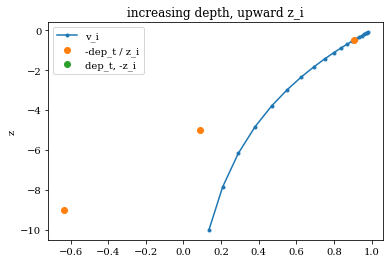

In [5]:
kwargs = {"z_dim":"s_rho", "b_extrap":0, "t_extrap":0}
di_z = gop.interp2z(-d_t, da.z_rho, da, zt_dim="depth", **kwargs).assign_coords(z=-d_t)
# this, below, would work
#di_z = gop.interp2z(-d_t.sortby("depth", ascending=False), da.z_rho, da, zt_dim="depth", **kwargs 
#                   ).assign_coords(z=-d_t.sortby("depth", ascending=False))
if xu.isnan(di_z).any():
    print("!!! i_z is nan")
di_d = gop.interp2z(d_t, -da.z_rho, da, zt_dim="depth", **kwargs).assign_coords(z=-d_t)
if xu.isnan(di_d).any():
    print("!!! di_d is nan")
    
da.plot(y="z_rho", marker=".", label="v_i")
di_z.plot(y="z", marker="o", linestyle="", label="-dep_t / z_i")
di_d.plot(y="z", marker="o", linestyle="", label="dep_t, -z_i")
plt.legend()
plt.title("increasing depth, upward z_i")


!!! di_d is nan


Text(0.5, 1.0, 'upward z_t, upward z_i')

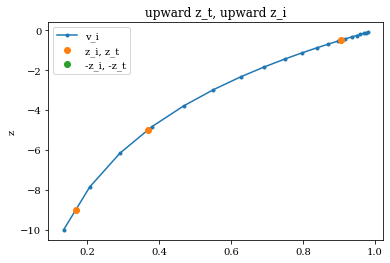

In [6]:
kwargs = {"z_dim":"s_rho", "b_extrap":0, "t_extrap":0}
di_z = gop.interp2z(z_t, da.z_rho, da, zt_dim="z", **kwargs).assign_coords(z=z_t)
if xu.isnan(di_z).any():
    print("!!! di_z is nan")
di_d = gop.interp2z(-z_t, -da.z_rho, da, zt_dim="z", **kwargs).assign_coords(z=z_t)
if xu.isnan(di_d).any():
    print("!!! di_d is nan")

da.plot(y="z_rho", marker=".", label="v_i")
di_z.plot(y="z", marker="o", linestyle="", label="z_i, z_t")
di_d.plot(y="z", marker="o", linestyle="", label="-z_i, -z_t")
plt.legend()
plt.title("upward z_t, upward z_i")

In [7]:
### Try directly with fast_interp
from crocosi.fast_interp3D import interp

# interp wants z_t, z_i, v_i, bot_itp, top_itp
# first three as 3D arrays with first axis being depth (or any axis to interpolate)

print("same order as above, using fast_interp")
print(interp(-np_dt[:,None,None], np_zi[:,None,None], temp[:,None,None], 0, 0).squeeze())
print(interp(np_dt[:,None,None], -np_zi[:,None,None], temp[:,None,None], 0, 0).squeeze())
print(interp(-np_dt[::-1,None,None], np_zi[:,None,None], temp[:,None,None], 0, 0).squeeze())
print(interp(np_dt[::-1,None,None], -np_zi[:,None,None], temp[:,None,None], 0, 0).squeeze())


same order as above, using fast_interp
[ 0.90489678  0.08837917 -0.63741426]
[nan nan nan]
[0.16916254 0.3692147  0.90489678]
[nan nan nan]
